# Neural Style Transfer

The goal of the project is to develop a Tensorflow version of the famous algorithm created by Gatys et al. (2015)(https://arxiv.org/abs/1508.06576). 
The algorithm allows to synthetize a new artificial picture copying the content of a first picture and the style from a second one.
This project is a rielaboration of an assignment from the Convolutional Neural Networks on Coursera by Andrew NG.

First of all, let's import all the needed packages.

In [8]:
import os
import sys
import scipy.io
import imageio
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
from nst_utils import *
import numpy as np
import tensorflow as tf

%matplotlib inline

## 1 - Problem Statement

Neural Style Transfer (NST) is a techniques in deep learning that allows to merge two images that, for a matter of simplicity, will be called "content" image (C) and a "style" image (S), to create a "generated" image (G). The generated image G combines the "content" of the image C with the "style" of image S. 

In this project, an image of the Louvre museum in Paris (content image C) will be mixed with a painting by Claude Monet, a leader of the impressionist movement (style image S), to generate the image on the right.
<img src="images/louvre_generated.png" style="width:750px;height:200px;">


## 2 - Approach: Transfer Learning

Neural Style Transfer (NST) uses a previously trained convolutional network, and builds on top of that. The idea of using a network trained on a different task and applying it to a new task is called transfer learning. 

Following the original NST paper (https://arxiv.org/abs/1508.06576), we will use the VGG network. Specifically, we'll use VGG-19, a 19-layer version of the VGG network. This model has already been trained on the very large ImageNet database, and thus has learned to recognize a variety of low level features (at the earlier layers) and high level features (at the deeper layers). 

Run the following code to load parameters from the VGG model. This may take a few seconds. 

In [2]:
model = load_vgg_model("pretrained-model/imagenet-vgg-verydeep-19.mat")
print(model)

{'input': <tf.Variable 'Variable:0' shape=(1, 300, 400, 3) dtype=float32_ref>, 'conv1_1': <tf.Tensor 'Relu:0' shape=(1, 300, 400, 64) dtype=float32>, 'conv1_2': <tf.Tensor 'Relu_1:0' shape=(1, 300, 400, 64) dtype=float32>, 'avgpool1': <tf.Tensor 'AvgPool:0' shape=(1, 150, 200, 64) dtype=float32>, 'conv2_1': <tf.Tensor 'Relu_2:0' shape=(1, 150, 200, 128) dtype=float32>, 'conv2_2': <tf.Tensor 'Relu_3:0' shape=(1, 150, 200, 128) dtype=float32>, 'avgpool2': <tf.Tensor 'AvgPool_1:0' shape=(1, 75, 100, 128) dtype=float32>, 'conv3_1': <tf.Tensor 'Relu_4:0' shape=(1, 75, 100, 256) dtype=float32>, 'conv3_2': <tf.Tensor 'Relu_5:0' shape=(1, 75, 100, 256) dtype=float32>, 'conv3_3': <tf.Tensor 'Relu_6:0' shape=(1, 75, 100, 256) dtype=float32>, 'conv3_4': <tf.Tensor 'Relu_7:0' shape=(1, 75, 100, 256) dtype=float32>, 'avgpool3': <tf.Tensor 'AvgPool_2:0' shape=(1, 38, 50, 256) dtype=float32>, 'conv4_1': <tf.Tensor 'Relu_8:0' shape=(1, 38, 50, 512) dtype=float32>, 'conv4_2': <tf.Tensor 'Relu_9:0' shap

The model is stored in a python dictionary where each variable name is the key and the corresponding value is a tensor containing that variable's value. To run an image through this network, you just have to feed the image to the model. This assigns the image as an input to the model. 

## 3 - Neural Style Transfer 

We will build the NST algorithm in three steps:

- Build the content cost function $J_{content}(C,G)$
- Build the style cost function $J_{style}(S,G)$
- Put it together to get $J(G) = \alpha J_{content}(C,G) + \beta J_{style}(S,G)$. 

### 3.1 - Computing the content cost

In our running example, the content image C will be the picture of the Louvre Museum in Paris.

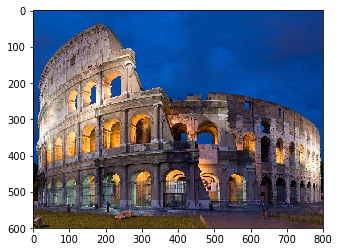

In [3]:
content_image = imageio.imread("images/coloseum.jpg")
imshow(content_image)

The content image (C) shows the Louvre museum's pyramid surrounded by old Paris buildings, against a sunny sky with a few clouds.

The first function to implement is the compute_cost_function, that will:
1. Retrieve dimensions from a_G: 
2. Unroll a_C and a_G as explained in the picture above
3. Compute the content cost

In [9]:
def compute_content_cost(a_C, a_G):
    """
    Computes the content cost
    
    Arguments:
    a_C -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image C 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image G
    
    Returns: 
    J_content -- scalar that you compute using equation 1 above.
    """
    
    # Retrieve dimensions from a_G (≈1 line)
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    print(n_C)
    print(n_W)
    print(n_H)
    # Reshape a_C and a_G (≈2 lines)
    a_C_unrolled = tf.reshape(a_C,[n_C,-1])
    a_G_unrolled = tf.reshape(a_G,[n_C,-1])
    
    # compute the cost with tensorflow (≈1 line)
    J_content = tf.reduce_sum(tf.squared_difference(a_C,a_G)/(4*n_H*n_W*n_C))
    print(J_content.get_shape())
    
    return J_content

Let's test the function

In [10]:
tf.reset_default_graph()

with tf.Session() as test:
    tf.set_random_seed(1)
    a_C = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    a_G = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    J_content = compute_content_cost(a_C, a_G)
    print("J_content = " + str(J_content.eval()))

3
4
4
()
J_content = 6.765593


**Expected Output**:

<table>
    <tr>
        <td>
            **J_content**
        </td>
        <td>
           6.76559
        </td>
    </tr>

</table>

### 3.2 - Computing the style cost

For our running example, we will use the following style image: 

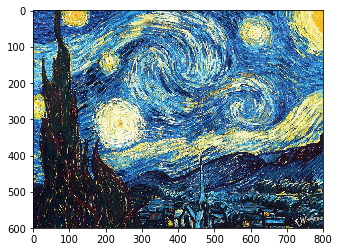

In [11]:
style_image = imageio.imread("images/starry_night_800600.jpg")
imshow(style_image)

This painting was painted in the style of *[impressionism](https://en.wikipedia.org/wiki/Impressionism)*.

We can now define a "style" const function $J_{style}(S,G)$. 

### 3.2.1 - Style matrix

The style matrix is also called a "Gram matrix." In linear algebra, the Gram matrix G of a set of vectors $(v_{1},\dots ,v_{n})$ is the matrix of dot products, whose entries are ${\displaystyle G_{ij} = v_{i}^T v_{j} = np.dot(v_{i}, v_{j})  }$. In other words, $G_{ij}$ compares how similar $v_i$ is to $v_j$: If they are highly similar, you would expect them to have a large dot product, and thus for $G_{ij}$ to be large. 

Note that there is an unfortunate collision in the variable names used here. We are following common terminology used in the literature, but $G$ is used to denote the Style matrix (or Gram matrix) as well as to denote the generated image $G$. We will try to make sure which $G$ we are referring to is always clear from the context. 

The result is a matrix of dimension $(n_C,n_C)$ where $n_C$ is the number of filters. The value $G_{ij}$ measures how similar the activations of filter $i$ are to the activations of filter $j$. 

One important part of the gram matrix is that the diagonal elements such as $G_{ii}$ also measures how active filter $i$ is. For example, suppose filter $i$ is detecting vertical textures in the image. Then $G_{ii}$ measures how common  vertical textures are in the image as a whole: If $G_{ii}$ is large, this means that the image has a lot of vertical texture. 

By capturing the prevalence of different types of features ($G_{ii}$), as well as how much different features occur together ($G_{ij}$), the Style matrix $G$ measures the style of an image. 

Now, a function that computes the Gram matrix of a matrix A will be implemented.

In [12]:
def gram_matrix(A):
    """
    Argument:
    A -- matrix of shape (n_C, n_H*n_W)
    
    Returns:
    GA -- Gram matrix of A, of shape (n_C, n_C)
    """
    
    GA = tf.tensordot(A,tf.transpose(A),axes=1)
    
    return GA

In [13]:
tf.reset_default_graph()

with tf.Session() as test:
    tf.set_random_seed(1)
    A = tf.random_normal([3, 2*1], mean=1, stddev=4)
    GA = gram_matrix(A)
    
    print("GA = " + str(GA.eval()))

GA = [[ 6.422305 -4.429122 -2.096682]
 [-4.429122 19.465837 19.563871]
 [-2.096682 19.563871 20.686462]]


### 3.2.2 - Style cost

**Expected Output**:

<table>
    <tr>
        <td>
            **GA**
        </td>
        <td>
           [[  6.42230511  -4.42912197  -2.09668207] <br>
 [ -4.42912197  19.46583748  19.56387138] <br>
 [ -2.09668207  19.56387138  20.6864624 ]]
        </td>
    </tr>

</table>

After generating the Style matrix (Gram matrix), your goal will be to minimize the distance between the Gram matrix of the "style" image S and that of the "generated" image G. For now, we are using only a single hidden layer $a^{[l]}$, and the corresponding style cost for this layer is defined as: 

$$J_{style}^{[l]}(S,G) = \frac{1}{4 \times {n_C}^2 \times (n_H \times n_W)^2} \sum _{i=1}^{n_C}\sum_{j=1}^{n_C}(G^{(S)}_{ij} - G^{(G)}_{ij})^2\tag{2} $$

where $G^{(S)}$ and $G^{(G)}$ are respectively the Gram matrices of the "style" image and the "generated" image, computed using the hidden layer activations for a particular hidden layer in the network.  


Let's compute now the style cost for a single layer in 3 steps:
1. Retrieve dimensions from the hidden layer activations a_G: 
2. Unroll the hidden layer activations a_S and a_G into 2D matrices, as explained in the picture above.
3. Compute the Style matrix of the images S and G.
4. Compute the Style cost:


In [14]:
def compute_layer_style_cost(a_S, a_G):
    """
    Arguments:
    a_S -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image S 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image G
    
    Returns: 
    J_style_layer -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    
    # Retrieve dimensions from a_G (≈1 line)
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    print(n_H,n_W,n_C)
    # Reshape the images to have them of shape (n_C, n_H*n_W) (≈2 lines)
    a_S = tf.reshape(a_S,[n_W*n_H,n_C])
    a_G = tf.reshape(a_G,[n_W*n_H,n_C])
    print(a_S, a_G)
    # Computing gram_matrices for both images S and G (≈2 lines)
    GS = gram_matrix(tf.transpose(a_S))
    GG = gram_matrix(tf.transpose(a_G))

    # Computing the loss (≈1 line)
    J_style_layer = tf.reduce_sum((GS-GG)**2)/(4*(n_C**2)*((n_H*n_W)**2))
    print(J_style_layer)
    
    return J_style_layer

### 3.2.3 Style Weights

So far we have captured the style from only one layer. We'll get better results if we "merge" style costs from several different layers. After completing this exercise, feel free to come back and experiment with different weights to see how it changes the generated image $G$. But for now, this is a pretty reasonable default: 

In [15]:
STYLE_LAYERS = [
    ('conv1_1', 0.2),
    ('conv2_1', 0.2),
    ('conv3_1', 0.2),
    ('conv4_1', 0.2),
    ('conv5_1', 0.2)]

In [16]:
tf.reset_default_graph()

with tf.Session() as test:
    tf.set_random_seed(1)
    a_S = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    a_G = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    J_style_layer = compute_layer_style_cost(a_S, a_G)
    
    print("J_style_layer = " + str(J_style_layer.eval()))

4 4 3
Tensor("Reshape:0", shape=(16, 3), dtype=float32) Tensor("Reshape_1:0", shape=(16, 3), dtype=float32)
Tensor("truediv:0", shape=(), dtype=float32)
J_style_layer = 9.190278


We can combine the style costs for different layers as follows:

$$J_{style}(S,G) = \sum_{l} \lambda^{[l]} J^{[l]}_{style}(S,G)$$

where the values for $\lambda^{[l]}$ are given in `STYLE_LAYERS`. 


**Expected Output**:

<table>
    <tr>
        <td>
            **J_style_layer**
        </td>
        <td>
           9.19028
        </td>
    </tr>

</table>

We've implemented a compute_style_cost(...) function. It simply calls your `compute_layer_style_cost(...)` several times, and weights their results using the values in `STYLE_LAYERS`. Read over it to make sure you understand what it's doing. 

<!-- 
2. Loop over (layer_name, coeff) from STYLE_LAYERS:
        a. Select the output tensor of the current layer. As an example, to call the tensor from the "conv1_1" layer you would do: out = model["conv1_1"]
        b. Get the style of the style image from the current layer by running the session on the tensor "out"
        c. Get a tensor representing the style of the generated image from the current layer. It is just "out".
        d. Now that you have both styles. Use the function you've implemented above to compute the style_cost for the current layer
        e. Add (style_cost x coeff) of the current layer to overall style cost (J_style)
3. Return J_style, which should now be the sum of the (style_cost x coeff) for each layer.
!--> 


In [17]:
def compute_style_cost(model, STYLE_LAYERS):
    """
    Computes the overall style cost from several chosen layers
    
    Arguments:
    model -- our tensorflow model
    STYLE_LAYERS -- A python list containing:
                        - the names of the layers we would like to extract style from
                        - a coefficient for each of them
    
    Returns: 
    J_style -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    
    # initialize the overall style cost
    J_style = 0

    for layer_name, coeff in STYLE_LAYERS:

        # Select the output tensor of the currently selected layer
        out = model[layer_name]

        # Set a_S to be the hidden layer activation from the layer we have selected, by running the session on out
        a_S = sess.run(out)

        # Set a_G to be the hidden layer activation from same layer. Here, a_G references model[layer_name] 
        # and isn't evaluated yet. Later in the code, we'll assign the image G as the model input, so that
        # when we run the session, this will be the activations drawn from the appropriate layer, with G as input.
        a_G = out
        
        # Compute style_cost for the current layer
        J_style_layer = compute_layer_style_cost(a_S, a_G)

        # Add coeff * J_style_layer of this layer to overall style cost
        J_style += coeff * J_style_layer

    return J_style

### 3.3 - Defining the total cost to optimize

Finally, let's create a cost function that minimizes both the style and the content cost. The formula is: 

$$J(G) = \alpha J_{content}(C,G) + \beta J_{style}(S,G)$$

Now we will implement the total cost function which includes both the content cost and the style cost. 

In [18]:
def total_cost(J_content, J_style, alpha = 10, beta = 40):
    """
    Computes the total cost function
    
    Arguments:
    J_content -- content cost coded above
    J_style -- style cost coded above
    alpha -- hyperparameter weighting the importance of the content cost
    beta -- hyperparameter weighting the importance of the style cost
    
    Returns:
    J -- total cost as defined by the formula above.
    """
    
    J = alpha*J_content+beta*J_style
    
    return J

## 4 - Solving the optimization problem

Finally, let's put everything together to implement Neural Style Transfer!


Here's what the program will do:

1. Create an Interactive Session
2. Load the content image 
3. Load the style image
4. Randomly initialize the image to be generated 
5. Load the VGG16 model
7. Build the TensorFlow graph:
    - Run the content image through the VGG16 model and compute the content cost
    - Run the style image through the VGG16 model and compute the style cost
    - Compute the total cost
    - Define the optimizer and the learning rate
8. Initialize the TensorFlow graph and run it for a large number of iterations, updating the generated image at every step.

</font>
Lets go through the individual steps in detail. 

You've previously implemented the overall cost $J(G)$. We'll now set up TensorFlow to optimize this with respect to $G$. To do so, your program has to reset the graph and use an "[Interactive Session](https://www.tensorflow.org/api_docs/python/tf/InteractiveSession)". Unlike a regular session, the "Interactive Session" installs itself as the default session to build a graph.  This allows you to run variables without constantly needing to refer to the session object, which simplifies the code.  

Lets start the interactive session.

In [58]:
# Reset the graph
tf.reset_default_graph()

# Start interactive session
sess = tf.InteractiveSession()

Let's load, reshape, and normalize our "content" image (the Louvre museum picture):

In [59]:
content_image = imageio.imread("images/piramids.jpg")
print(content_image.shape)
content_image = reshape_and_normalize_image(content_image)
print(content_image.shape)


(300, 400, 3)
(1, 300, 400, 3)


Let's load, reshape and normalize our "style" image (Claude Monet's painting):

In [60]:
style_image = imageio.imread("images/bonnard.jpg")
print(style_image.shape)

style_image = reshape_and_normalize_image(style_image)
print(style_image.shape)


(300, 400, 3)
(1, 300, 400, 3)


Now, we initialize the "generated" image as a noisy image created from the content_image. By initializing the pixels of the generated image to be mostly noise but still slightly correlated with the content image, this will help the content of the "generated" image more rapidly match the content of the "content" image.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


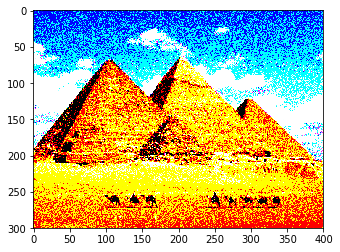

In [61]:
generated_image = generate_noise_image(content_image)
imshow(generated_image[0])

Next, as explained in part (2), let's load the VGG16 model.

In [62]:
model = load_vgg_model("pretrained-model/imagenet-vgg-verydeep-19.mat")

To get the program to compute the content cost, we will now assign `a_C` and `a_G` to be the appropriate hidden layer activations. We will use layer `conv4_2` to compute the content cost. The code below does the following:

1. Assign the content image to be the input to the VGG model.
2. Set a_C to be the tensor giving the hidden layer activation for layer "conv4_2".
3. Set a_G to be the tensor giving the hidden layer activation for the same layer. 
4. Compute the content cost using a_C and a_G.

In [63]:
# Assign the content image to be the input of the VGG model.  
sess.run(model['input'].assign(content_image))

# Select the output tensor of layer conv4_2
out = model['conv4_2']

# Set a_C to be the hidden layer activation from the layer we have selected
a_C = sess.run(out)

# Set a_G to be the hidden layer activation from same layer. Here, a_G references model['conv4_2'] 
# and isn't evaluated yet. Later in the code, we'll assign the image G as the model input, so that
# when we run the session, this will be the activations drawn from the appropriate layer, with G as input.
a_G = out

# Compute the content cost
J_content = compute_content_cost(a_C, a_G)

512
50
38
()


**Note**: At this point, a_G is a tensor and hasn't been evaluated. It will be evaluated and updated at each iteration when we run the Tensorflow graph in model_nn() below.

In [64]:
# Assign the input of the model to be the "style" image 
sess.run(model['input'].assign(style_image))

# Compute the style cost
J_style = compute_style_cost(model, STYLE_LAYERS)

300 400 64
Tensor("Reshape_2:0", shape=(120000, 64), dtype=float32) Tensor("Reshape_3:0", shape=(120000, 64), dtype=float32)
Tensor("truediv_1:0", shape=(), dtype=float32)
150 200 128
Tensor("Reshape_4:0", shape=(30000, 128), dtype=float32) Tensor("Reshape_5:0", shape=(30000, 128), dtype=float32)
Tensor("truediv_2:0", shape=(), dtype=float32)
75 100 256
Tensor("Reshape_6:0", shape=(7500, 256), dtype=float32) Tensor("Reshape_7:0", shape=(7500, 256), dtype=float32)
Tensor("truediv_3:0", shape=(), dtype=float32)
38 50 512
Tensor("Reshape_8:0", shape=(1900, 512), dtype=float32) Tensor("Reshape_9:0", shape=(1900, 512), dtype=float32)
Tensor("truediv_4:0", shape=(), dtype=float32)
19 25 512
Tensor("Reshape_10:0", shape=(475, 512), dtype=float32) Tensor("Reshape_11:0", shape=(475, 512), dtype=float32)
Tensor("truediv_5:0", shape=(), dtype=float32)


Now that we have J_content and J_style, compute the total cost J by calling `total_cost()`. Use `alpha = 10` and `beta = 40`.

In [65]:
J = total_cost(J_content, J_style, alpha = 10, beta = 40)

In [66]:
# define optimizer (1 line)
optimizer = tf.train.AdamOptimizer(2.0)

# define train_step (1 line)
train_step = optimizer.minimize(J)

We will now implement the model_nn() function which initializes the variables of the tensorflow graph, assigns the input image (initial generated image) as the input of the VGG16 model and runs the train_step for a large number of steps.

In [67]:
def model_nn(sess, input_image, num_iterations = 140):
    
    # Initialize global variables (you need to run the session on the initializer)
    sess.run(tf.global_variables_initializer())
    
    # Run the noisy input image (initial generated image) through the model. Use assign().
    sess.run(model['input'].assign(input_image))
    
    for i in range(num_iterations):
    
        # Run the session on the train_step to minimize the total cost
        _ = sess.run(train_step)
        
        # Compute the generated image by running the session on the current model['input']
        generated_image = sess.run(model['input'])

        # Print every 20 iteration.
        if i%20 == 0:
            Jt, Jc, Js = sess.run([J, J_content, J_style])
            print("Iteration " + str(i) + " :")
            print("total cost = " + str(Jt))
            print("content cost = " + str(Jc))
            print("style cost = " + str(Js))
            
            # save current generated image in the "/output" directory
            save_image("output/" + str(i) + ".png", generated_image)
    
    # save last generated image
    save_image('output/generated_image.jpg', generated_image)
    
    return generated_image

Run the following cell to generate an artistic image. It should take about 3min on CPU for every 20 iterations but you start observing attractive results after ≈140 iterations. Neural Style Transfer is generally trained using GPUs.

In [68]:
model_nn(sess, generated_image, num_iterations=140)

Iteration 0 :
total cost = 9051628000.0
content cost = 9192.3955
style cost = 226288380.0
Iteration 20 :
total cost = 1215423700.0
content cost = 20524.887
style cost = 30380462.0
Iteration 40 :
total cost = 296188160.0
content cost = 22040.738
style cost = 7399194.0
Iteration 60 :
total cost = 167565070.0
content cost = 22746.182
style cost = 4183440.2
Iteration 80 :
total cost = 122215070.0
content cost = 23214.205
style cost = 3049573.2
Iteration 100 :
total cost = 96795640.0
content cost = 23496.504
style cost = 2414016.8
Iteration 120 :
total cost = 79588536.0
content cost = 23704.723
style cost = 1983787.2


array([[[[  23.18874  ,  -13.986103 ,   -4.0148344],
         [ -76.2845   ,  -66.192314 ,  -26.470554 ],
         [ -47.78624  ,  -20.957516 ,   -9.964963 ],
         ...,
         [  -5.189464 ,   41.913403 ,   89.041504 ],
         [   6.565112 ,   63.61801  ,  106.97678  ],
         [ -32.080143 ,   11.344679 ,   63.24349  ]],

        [[  11.888822 ,    1.7822185,    4.49808  ],
         [ -54.04463  ,  -52.454792 ,  -34.425014 ],
         [ -57.8363   ,  -41.13975  ,  -18.701836 ],
         ...,
         [ -43.845787 ,   36.829826 ,   80.45938  ],
         [ -53.378387 ,   20.956533 ,   97.3581   ],
         [ -72.09408  ,  -42.06861  ,   12.945076 ]],

        [[  -4.6667476,   23.314352 ,   45.989086 ],
         [  -6.494567 ,  -33.470417 ,   -2.8294103],
         [ -69.11548  ,  -21.298567 ,  -19.878067 ],
         ...,
         [-130.75203  ,   -8.089401 ,   52.44336  ],
         [-112.755585 ,   -7.352557 ,   94.57575  ],
         [ -77.70889  ,   -9.182487 ,   42.62692  ]],

**Expected Output**:

<table>
    <tr>
        <td>
            **Iteration 0 : **
        </td>
        <td>
           total cost = 5.05035e+09 <br>
           content cost = 7877.67 <br>
           style cost = 1.26257e+08
        </td>
    </tr>

</table>

After running this, in the upper bar of the notebook click on "File" and then "Open". Go to the "/output" directory to see all the saved images. Open "generated_image" to see the generated image! :)

You should see something the image presented below on the right:

<img src="images/louvre_generated.png" style="width:800px;height:300px;">

We didn't want you to wait too long to see an initial result, and so had set the hyperparameters accordingly. To get the best looking results, running the optimization algorithm longer (and perhaps with a smaller learning rate) might work better. After completing and submitting this assignment, we encourage you to come back and play more with this notebook, and see if you can generate even better looking images. 

Here are few other examples:

- The beautiful ruins of the ancient city of Persepolis (Iran) with the style of Van Gogh (The Starry Night)
<img src="images/perspolis_vangogh.png" style="width:750px;height:300px;">

- The tomb of Cyrus the great in Pasargadae with the style of a Ceramic Kashi from Ispahan.
<img src="images/pasargad_kashi.png" style="width:750px;height:300px;">


### References:

The Neural Style Transfer algorithm was due to Gatys et al. (2015). Harish Narayanan and Github user "log0" also have highly readable write-ups from which we drew inspiration. The pre-trained network used in this implementation is a VGG network, which is due to Simonyan and Zisserman (2015). Pre-trained weights were from the work of the MathConvNet team. 

- Leon A. Gatys, Alexander S. Ecker, Matthias Bethge, (2015). A Neural Algorithm of Artistic Style (https://arxiv.org/abs/1508.06576) 
- Harish Narayanan, Convolutional neural networks for artistic style transfer. https://harishnarayanan.org/writing/artistic-style-transfer/
- Log0, TensorFlow Implementation of "A Neural Algorithm of Artistic Style". http://www.chioka.in/tensorflow-implementation-neural-algorithm-of-artistic-style
- Karen Simonyan and Andrew Zisserman (2015). Very deep convolutional networks for large-scale image recognition (https://arxiv.org/pdf/1409.1556.pdf)
- MatConvNet. http://www.vlfeat.org/matconvnet/pretrained/
